In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import numpy as np



def initialize(timesteps):
    ''' initialize the physical system, horizontal grid size, etc
    '''  
    # below are the parameters that can be varied
    dx = 100.0
    u = 500.0
    dt = 0.01
    Numpoints = 100
    shift = 1000#20
    c_0 = 1
    alpha = 0.01
    epsilon = 0.0001
    
# create the concentration matrix and initialize it
    cmatrix = np.zeros((timesteps+1, Numpoints+4))
    cmatrix[0, 2:Numpoints+2]= c_0 * np.exp(- alpha * (np.arange(0,Numpoints)* dx -shift)**2)
    
# set the boundary points
    cmatrix = boundary_conditions(cmatrix, 0, Numpoints)

    return dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix

def boundary_conditions(cmatrix, time, Numpoints):
    '''Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    '''
    cmatrix[0, 0] = cmatrix[1, Numpoints-1]
    cmatrix[0, 1] = cmatrix[1, Numpoints]
    cmatrix[0, Numpoints+2] = cmatrix[1, 3]
    cmatrix[0, Numpoints+3] = cmatrix[1, 4]

    return cmatrix

def advect3_gettable(order, Numpoints,string):
    
    '''read in the corresponding coefficient table for the calculation of coefficients for advection3
    '''

# create a matrix to store the table to be read in
    temp = np.zeros(5)
    ltable = np.zeros((order + 1, 5))
    if string =='O':
        fname = 'numeric/numlabs/lab10/Tables/l{0}_table.txt'.format(order)
    if string =='M':
        fname = 'numeric/numlabs/lab10/Tables2/l{0}_table.txt'.format(order)
    fp = open(fname, 'r')
 
    for i in range(order+1):
        line = fp.readline()
        temp = line.split()
        ltable[i, :]= temp
        
    fp.close()
    print ('Matrix of Bott Scheme: %s'%ltable)
    return ltable

    

def make_graph(cmatrix, timesteps, Numpoints, dt):
    """Create graphs of the model results using matplotlib.
    """

    # Create a figure with size 15, 5
    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    
    # Set the figure title, and the axes labels.
    the_title = fig.text(0.25, 0.95, 'Concentrations Results from t = %.3fs to %.3fs' % (0, dt*timesteps))
    ax.set_ylabel('Concentration')
    ax.set_xlabel('Grid Point')

    # We use color to differentiate lines at different times.  Set up the color map
    cmap = plt.get_cmap('spectral')
    cNorm  = colors.Normalize(vmin=0, vmax=1.*timesteps)
    cNorm_inseconds = colors.Normalize(vmin=0, vmax=1.*timesteps*dt)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    # Only try to plot 20 lines, so choose an interval if more than that (i.e. plot
    # every interval lines
    #interval = np.int(np.ceil(timesteps/20))

    # Do the main plot
    for time in range(timesteps):
        colorVal = scalarMap.to_rgba(time)
        ax.plot(cmatrix[time, :], color=colorVal)

    # Add the custom colorbar
    ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
    cb1 = colorbar.ColorbarBase(ax2, cmap=cmap, norm=cNorm_inseconds)
    cb1.set_label('Time (s)')

    return

def advection3(timesteps, order,string):
    ''' Entry point for the Bott Scheme'''
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    ltable = advect3_gettable(order, Numpoints,string)
    cmatrix = step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon)
    #make_graph(cmatrix, timesteps, Numpoints, dt)
    return cmatrix, timesteps, Numpoints, dt
    

In [14]:
def step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon):
    '''Step algorithm for Bott Scheme'''
    
# create a matrix to store the current coefficients a(j, k)
    amatrix = np.zeros((order+1, Numpoints))
    
    for timecount in range(0,timesteps):
        for base in range(0,5):
            amatrix[0:order+1, 0:Numpoints] += np.dot(
                ltable[0:order+2, base:base+1], 
                cmatrix[timecount:timecount+1, 0+base:Numpoints+base])
        

# calculate I of c at j+1/2 , as well as I at j
# as these values will be needed to calculate i at j+1/2 , as
# well as i at j
    
# calculate I of c at j+1/2(Iplus), 
# and at j(Iatj)
        Iplus = np.zeros(Numpoints)
        Iatj = np.zeros(Numpoints)

        tempvalue= 1 - 2*u*dt/dx #the last term at the Flux leaving Eqn
        for k in range(order+1):
            Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))#I of c at j+1/2
            Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))             #I of c at j
        Iplus[Iplus < 0] = 0
        Iatj = np.maximum(Iatj, Iplus + epsilon)
    
# finally, calculate the current concentration (equattion (A) at page 10)
        cmatrix[timecount+1, 3:Numpoints+2] = (
        
            cmatrix[timecount, 3:Numpoints+2] * 
            (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
        
             cmatrix[timecount, 2:Numpoints+1]* 
             Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])
               
# set the boundary condition at the first point
        cmatrix[timecount+1, 2]= cmatrix[timecount+1, Numpoints+1]
# set the other boundary points
        cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)

    return cmatrix

Matrix of Bott Scheme: [[ 0.   0.   1.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0. ]
 [ 0.   0.5 -1.   0.5  0. ]]
(100,)
(100,)
(100,)
(100,)
(100,)


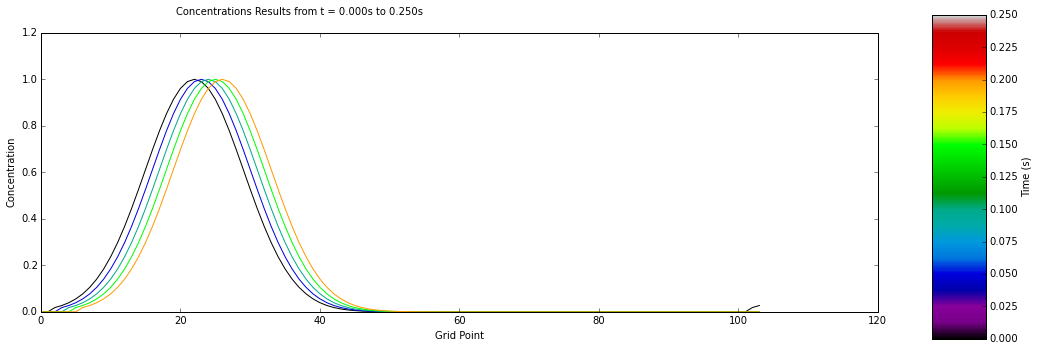

In [8]:
%matplotlib inline
#u=20m/s
t=5
cmatrix, timesteps, Numpoints, dt=advection3(t,2,'O') #24*3600*20,24h
make_graph(cmatrix, timesteps, Numpoints, dt)

Matrix of Bott Scheme: [[ 0.   0.   1.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0. ]
 [ 0.   0.5 -1.   0.5  0. ]]


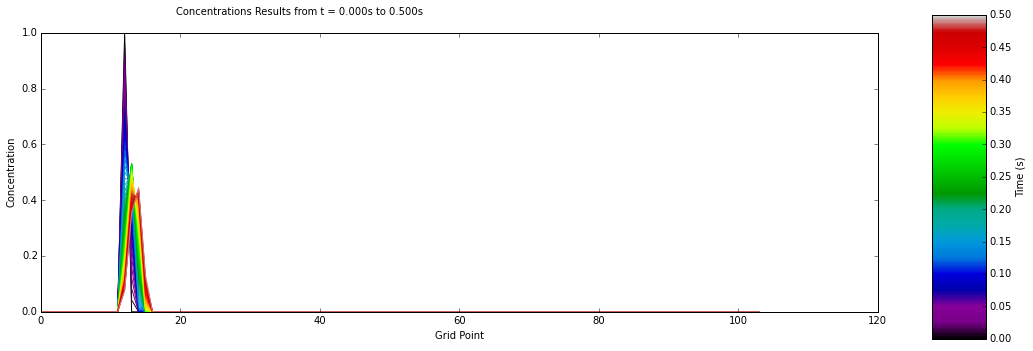

In [15]:
%matplotlib inline
#u=5m/s
t=50
cmatrix, timesteps, Numpoints, dt=advection3(t,2,'O') #24*3600*20,24h
make_graph(cmatrix, timesteps, Numpoints, dt)

In [49]:
help (np.dot)

Help on built-in function dot in module numpy.core.multiarray:

dot(...)
    dot(a, b, out=None)
    
    Dot product of two arrays.
    
    For 2-D arrays it is equivalent to matrix multiplication, and for 1-D
    arrays to inner product of vectors (without complex conjugation). For
    N dimensions it is a sum product over the last axis of `a` and
    the second-to-last of `b`::
    
        dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])
    
    Parameters
    ----------
    a : array_like
        First argument.
    b : array_like
        Second argument.
    out : ndarray, optional
        Output argument. This must have the exact kind that would be returned
        if it was not used. In particular, it must have the right type, must be
        C-contiguous, and its dtype must be the dtype that would be returned
        for `dot(a,b)`. This is a performance feature. Therefore, if these
        conditions are not met, an exception is raised, instead of attempting
        to be flex